# Simples inferência usando um modelo pré-treinado (Prithvi-E0-2.0, 600 M de parâmetros) para um caso de identificação de resquícios de incêndio.

In [1]:
import argparse
import os
from typing import List, Union
import re
import datetime
import numpy as np
import rasterio
import torch
import rioxarray
import yaml
from einops import rearrange
from terratorch.cli_tools import LightningInferenceModel
from terratorch.utils import view_api

/home/jalmeida/.pyenv/versions/3.11.10/envs/terratorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Alguns paramêtros globais

In [2]:
NO_DATA = -9999
NO_DATA_FLOAT = 0.0001
OFFSET = 0
PERCENTILE = 99

### Abaixo, funções auxiliares, necessaŕias para pré e pós-processar os dados.

In [3]:
def process_channel_group(orig_img, channels):
    """
    Args:
        orig_img: torch.Tensor representing original image (reference) with shape = (bands, H, W).
        channels: list of indices representing RGB channels.

    Returns:
        torch.Tensor with shape (num_channels, height, width) for original image
    """

    orig_img = orig_img[channels, ...]
    valid_mask = torch.ones_like(orig_img, dtype=torch.bool)
    valid_mask[orig_img == NO_DATA_FLOAT] = False


    # Rescale (enhancing contrast)
    max_value = max(3000, np.percentile(orig_img[valid_mask], PERCENTILE))
    min_value = OFFSET

    orig_img = torch.clamp((orig_img - min_value) / (max_value - min_value), 0, 1)

    # No data as zeros
    orig_img[~valid_mask] = 0

    return orig_img

In [4]:
def read_geotiff(file_path: str):
    """Read all bands from *file_path* and return image + meta info.

    Args:
        file_path: path to image file.

    Returns:
        np.ndarray with shape (bands, height, width)
        meta info dict
    """

    with rasterio.open(file_path) as src:
        img = src.read()
        meta = src.meta
        try:
            coords = src.lnglat()
        except:
            # Cannot read coords
            coords = None

    return img, meta, coords

In [5]:
def save_geotiff(image, output_path: str, meta: dict):
    """Save multi-band image in Geotiff file.

    Args:
        image: np.ndarray with shape (bands, height, width)
        output_path: path where to save the image
        meta: dict with meta info.
    """

    with rasterio.open(output_path, "w", **meta) as dest:
        for i in range(image.shape[0]):
            dest.write(image[i, :, :], i + 1)

    return

In [6]:
def _convert_np_uint8(float_image: torch.Tensor):
    image = float_image.numpy() * 255.0
    image = image.astype(dtype=np.uint8)

    return image

In [7]:
def load_example(
    file_paths: List[str],
    mean: List[float] = None,
    std: List[float] = None,
    indices: Union[list[int], None] = None,
):
    """Build an input example by loading images in *file_paths*.

    Args:
        file_paths: list of file paths .
        mean: list containing mean values for each band in the images in *file_paths*.
        std: list containing std values for each band in the images in *file_paths*.

    Returns:
        np.array containing created example
        list of meta info for each image in *file_paths*
    """

    imgs = []
    metas = []
    temporal_coords = []
    location_coords = []

    for file in file_paths:
        img, meta, coords = read_geotiff(file)

        # Rescaling (don't normalize on nodata)
        img = np.moveaxis(img, 0, -1)  # channels last for rescaling
        if indices is not None:
            img = img[..., indices]
        if mean is not None and std is not None:
            img = np.where(img == NO_DATA, NO_DATA_FLOAT, (img - mean) / std)

        imgs.append(img)
        metas.append(meta)
        if coords is not None:
            location_coords.append(coords)

        try:
            match = re.search(r'(\d{7,8}T\d{6})', file)
            if match:
                year = int(match.group(1)[:4])
                julian_day = match.group(1).split('T')[0][4:]
                if len(julian_day) == 3:
                    julian_day = int(julian_day)
                else:
                    julian_day = datetime.datetime.strptime(julian_day, '%m%d').timetuple().tm_yday
                temporal_coords.append([year, julian_day])
        except Exception as e:
            print(f'Could not extract timestamp for {file} ({e})')

    imgs = np.stack(imgs, axis=0)  # num_frames, H, W, C
    imgs = np.moveaxis(imgs, -1, 0).astype("float32")  # C, num_frames, H, W
    imgs = np.expand_dims(imgs, axis=0)  # add batch di

    return imgs, temporal_coords, location_coords, metas

In [8]:
def run_model(input_data, model, datamodule, img_size):
    # Reflect pad if not divisible by img_size
    original_h, original_w = input_data.shape[-2:]
    pad_h = (img_size - (original_h % img_size)) % img_size
    pad_w = (img_size - (original_w % img_size)) % img_size
    input_data = np.pad(
        input_data, ((0, 0), (0, 0), (0, 0), (0, pad_h), (0, pad_w)), mode="reflect"
    )

    # Build sliding window

    batch_size = 1
    batch = torch.tensor(input_data, device="cpu")
    windows = batch.unfold(3, img_size, img_size).unfold(4, img_size, img_size)
    h1, w1 = windows.shape[3:5]
    windows = rearrange(
        windows, "b c t h1 w1 h w -> (b h1 w1) c t h w", h=img_size, w=img_size
    )

    # Split into batches if number of windows > batch_size
    num_batches = windows.shape[0] // batch_size if windows.shape[0] > batch_size else 1
    windows = torch.tensor_split(windows, num_batches, dim=0)

    # Run model
    pred_imgs = []
    for x in windows:
        # Apply standardization
        x = datamodule.test_transform(image=x.squeeze().numpy().transpose(1,2,0))
        x['image'] = x['image'].unsqueeze(0)
        x = datamodule.aug(x)['image']

        with torch.no_grad():
            x = x.to(model.device)
            pred = model(x)
            pred = pred.output.detach().cpu()

        y_hat = pred.argmax(dim=1)

        y_hat = torch.nn.functional.interpolate(y_hat.unsqueeze(1).float(), size=img_size, mode="nearest")

        pred_imgs.append(y_hat)

    pred_imgs = torch.concat(pred_imgs, dim=0)

    # Build images from patches
    pred_imgs = rearrange(
        pred_imgs,
        "(b h1 w1) c h w -> b c (h1 h) (w1 w)",
        h=img_size,
        w=img_size,
        b=1,
        c=1,
        h1=h1,
        w1=w1,
    )

    # Cut padded area back to original size
    pred_imgs = pred_imgs[..., :original_h, :original_w]

    # Squeeze (batch size 1)
    pred_imgs = pred_imgs[0]

    return pred_imgs

### Definindo variáveis requiridas pela inferência.

In [9]:
output_dir = "./inference_output"
config = "burn_scars_config_tiled.yaml"
checkpoint = "checkpoints/Prithvi_EO_V2_300M_BurnScars.pt"
data_file = "data/examples/subsetted_512x512_HLS.S30.T10SEH.2018190.v1.4_merged.tif"
input_indices = [0,1,2,3,4,5]
img_size = 512

In [10]:
os.makedirs(output_dir, exist_ok=True)

### Carregando o arquivo de configuração (YAML) na memória. 

In [11]:
with open(config, "r") as f:
    config_dict = yaml.safe_load(f)

### Carregando o modelo para a memória.
As informações contidas no arquivo YAML, no campo `model`, são suficientes para restaurar completamente o modelo para a meómória. 

In [12]:
lightning_model = LightningInferenceModel.from_config(config, checkpoint)

/home/jalmeida/.pyenv/versions/3.11.10/envs/terratorch/lib/python3.11/site-packages/lightning/pytorch/cli.py:528: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['-f', '/home/jalmeida/.local/share/jupyter/runtime/kernel-064f2210-fc59-47d7-909c-a468edddfe55.json'], args=['--config', 'burn_scars_config_tiled.yaml'].
Seed set to 2
INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed
/home/jalmeida/.pyenv/versions/3.11.10/envs/terratorch/lib/

[<lightning.pytorch.callbacks.early_stopping.EarlyStopping object at 0x7f370053fd50>, <lightning.pytorch.callbacks.lr_monitor.LearningRateMonitor object at 0x7f36ff942e50>, <terratorch.cli_tools.CustomWriter object at 0x7f36ff96b0d0>]


É possível ter-se uma noção das camadas presentes no modelo simplesmente imprimindo o atributo `model`, que contém, de fato, a rede neural que estamos usando. 

In [13]:
lightning_model.model

SemanticSegmentationTask(
  (model): PixelWiseModel(
    (encoder): PrithviViT(
      (patch_embed): PatchEmbed(
        (proj): Conv3d(6, 1024, kernel_size=(1, 16, 16), stride=(1, 16, 16))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-23): 24 x Block(
          (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate='none')
  

### Carregando dados

In [14]:
input_data, temporal_coords, location_coords, meta_data = load_example(
    file_paths=[data_file], indices=input_indices,
)
meta_data = meta_data[0]  # only one image

if input_data.mean() > 1:
    input_data = input_data / 10000  # Convert to range 0-1


### Executando uma inferência usando o modelo.

In [15]:
lightning_model.model.eval()

channels = config_dict['data']['init_args']['rgb_indices']

pred = run_model(input_data, lightning_model.model, lightning_model.datamodule, img_size)

### Visualizando a imagem de entrada.
Reordenamos as bandas do arquivo para correspondem à sequência RGB ($[2,1,0]$ no nosso caso) e adicionamos um desvio para mo branco ($0,20$) para clarear a figura.

In [16]:
import rioxarray
fp = rioxarray.open_rasterio(data_file)

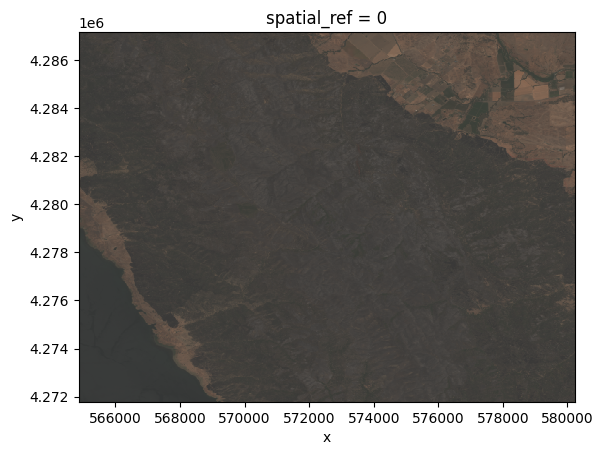

In [17]:
(fp[[2,1,0]]+0.20).plot.imshow(rgb="band")

### Visualizando a imagem de saída. 
Em amarelo a região afetada pelo incêndio, segundo a estimativa do modelo. 

In [18]:
import matplotlib.pyplot as plt

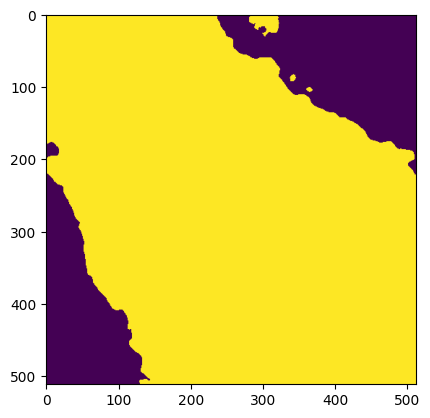

In [19]:
plt.imshow(pred[0])

### Uma tentativa de visualização do modelo.

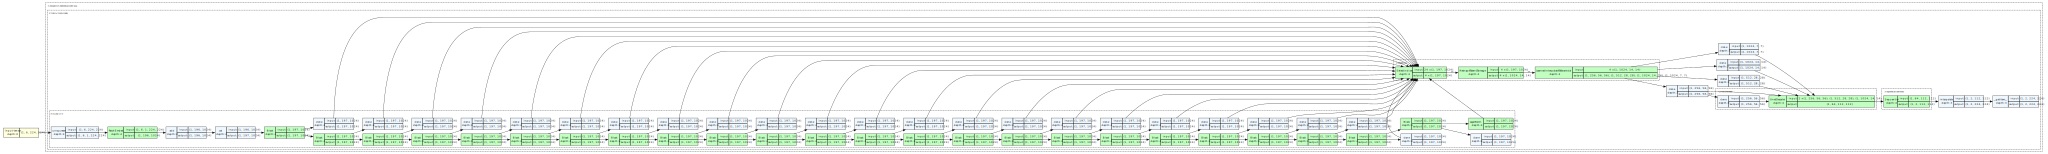

In [20]:
trial_data = torch.zeros(1, 6, 224, 224)
view_api(lightning_model.model, input_data=trial_data, config={"expand_nested":True, "depth":4, "graph_dir": "LR"})